#  Tutorial of Seq2seq with Attention

### 1) Read Data

reference : https://www.tensorflow.org/tutorials/text/nmt_with_attention?hl=zh_cn

In [0]:
import json
import io
import re
import os
import time
import random
import tensorflow as tf
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import unicodedata
from sklearn.model_selection import train_test_split

In [2]:
# %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.2.0-rc4
Running on TPU  ['10.47.92.186:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.47.92.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.47.92.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [0]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

### 2) Text PreProcessing

####(1) Text Cleaning

In [0]:
# 将 unicode 文件转换为 ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

In [0]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"}

In [0]:
def preprocess_sentence(sentence):
    
    sentence = unicode_to_ascii(sentence.lower().strip())
    
    sentence = " ".join([contractions[word] if word in contractions else word for word in sentence.split(' ') ])
    
    # 在单词与跟在其后的标点符号之间插入一个空格
    # 例如： "he is a boy." => "he is a boy ."
    # 参考：https://stackoverflosentence.com/questions/3645931/python-padding-punctuation-sentenceith-sentencehite-spaces-keeping-punctuation
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)

    sentence = sentence.rstrip().strip()

    # 给句子加上开始和结束标记
    # 以便模型知道何时开始和结束预测
    sentence = '<start> ' + sentence + ' <end>'
    return sentence

In [7]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [0]:
# 1. 去除重音符号
# 2. 清理句子
# 3. 返回这样格式的单词对：[ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')[:-1]

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [0]:
en, sp = create_dataset(path_to_file, None)

In [10]:
print(en[20000])
print(sp[20000])

<start> i do not like movies . <end>
<start> no me gustan las peliculas . <end>


#### (2) sentence tokenizing

In [0]:
def max_length(tensor):
    return max(len(t) for t in tensor)

def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    
    lang_tokenizer.fit_on_texts(lang)
    
    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
    
    return tensor, lang_tokenizer

# def load_dataset(path, num_examples=None):
#     # 创建清理过的输入输出对
#     targ_lang, inp_lang = create_dataset(path, num_examples)

#     input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
#     target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

#     return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
    # 创建清理过的输入输出对
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [0]:
# 尝试实验不同大小的数据集
num_examples = 30000
input_tensor, output_tensor, input_tokenizer, output_tokenizer = load_dataset(path_to_file, num_examples)

# 计算目标张量的最大长度 （max_length）
max_length_targ, max_length_inp = max_length(output_tensor), max_length(input_tensor)

In [0]:
max_length_output, max_length_input = max_length(output_tensor), max_length(input_tensor)

In [15]:
# 采用 80 - 20 的比例切分训练集和验证集
input_tensor_train, input_tensor_val, output_tensor_train, output_tensor_val = train_test_split(input_tensor, output_tensor, test_size=0.2)

# 显示长度
print(len(input_tensor_train), len(output_tensor_train), len(input_tensor_val), len(output_tensor_val))

24000 24000 6000 6000


In [0]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [17]:
input_tensor_train[1000]

array([   1,    4,   17,   16, 2283,    3,    2,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [18]:
print ("Input Language; index to word mapping")
convert(input_tokenizer, input_tensor_train[200])
print ()
print ("Target Language; index to word mapping")
convert(output_tokenizer, output_tensor_train[200])

Input Language; index to word mapping
1 ----> <start>
37 ----> tengo
1011 ----> muchas
1564 ----> ideas
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
23 ----> have
9 ----> a
147 ----> lot
58 ----> of
1054 ----> ideas
3 ----> .
2 ----> <end>


#### (3) DataSet Creating

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, output_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [21]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [22]:
example_input_batch.shape

TensorShape([64, 16])

In [0]:
# example_input_batch

### 2) Encoder

##### 2) Model

In [0]:
class Encoder(tf.keras.Model):
    def __init__(self,vocab_size,embedding_dim,encode_units,batch_size):
        super(Encoder,self).__init__()
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.encode_units = encode_units
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,self.embedding_dim)
        self.gru = tf.keras.layers.GRU(units=self.encode_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        
    
    def call(self,x,hidden_state):
        encoder_embedding = self.embedding(x)
        encode_output,encode_hidden_state = self.gru(encoder_embedding,initial_state = hidden_state)
        
        return encode_output,encode_hidden_state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.encode_units))
        

In [0]:
INPUT_VOCAB_SIZE = len(input_tokenizer.word_index)+1
ENCODER_EMBEDDING_SIZE = 256
UNITS = 1024

In [26]:
INPUT_VOCAB_SIZE

9414

In [0]:
encoder = Encoder(INPUT_VOCAB_SIZE,ENCODER_EMBEDDING_SIZE,UNITS,BATCH_SIZE)

In [0]:
encode_initial_hidden_state = encoder.initialize_hidden_state()

In [0]:
encode_output,encode_hidden_state = encoder(example_input_batch,encode_initial_hidden_state)

### 3) Decoder

In [0]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self,attention_unit):
        super(BahdanauAttention,self).__init__()
        self.W1 = tf.keras.layers.Dense(attention_unit)
        self.W2 = tf.keras.layers.Dense(attention_unit)
        self.V  = tf.keras.layers.Dense(1)
        
        
    def call(self,hidden_state,encode_output):
        ### enc_ouput [batch_size,sequence_size,units]
        hidden_state = tf.expand_dims(hidden_state,axis = 1)

        logits = self.V(tf.nn.tanh(self.W1(hidden_state) + self.W2(encode_output)))
        
        score  = tf.nn.softmax(logits,axis = 1)
        
        context_vector = encode_output*score
        
        context_vector = tf.reduce_sum(context_vector,axis = 1)
        
        return context_vector,score
        
          

In [0]:
attention_layer = BahdanauAttention(UNITS)

In [0]:
# context_vector,score = attention_layer(encode_hidden_state,encode_output)

##### 2) Model

In [0]:
class Decoder(tf.keras.Model):
    def __init__(self,vocab_size,decode_unit,embedding_dim):
        super(Decoder,self).__init__()
        self.vocab_size = vocab_size
        self.decode_unit = decode_unit
        self.embedding_dim = embedding_dim
        
        self.attention_layer = BahdanauAttention(self.decode_unit)

        self.gru =  tf.keras.layers.GRU(units=self.decode_unit,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        
        self.embeddding = tf.keras.layers.Embedding(self.vocab_size,self.embedding_dim)
        
        self.fc = tf.keras.layers.Dense(self.vocab_size)
        
        
    def call(self,decode_input,hidden_state,encode_output):
        
        decode_input = self.embeddding(decode_input) #### [batch_size,embedding_size]
        
        context_vector,score = self.attention_layer(hidden_state,encode_output)

        x = tf.concat([tf.expand_dims(context_vector, 1), tf.expand_dims(decode_input,1)], axis=-1)
        
        decode_output, hidden_state = self.gru(x)
        
        decode_output = tf.reshape(decode_output, (-1, decode_output.shape[2]))
        
#         decode_output = tf.reduce_sum(decode_output,axis = 1)
        
        y = self.fc(decode_output)
        
        return y,hidden_state,score
        

In [0]:
### parameter
OUTPUR_VOCAB_SIZE = len(output_tokenizer.word_index)+1

ENCODE_EMBEDDING_DIM = 256

In [0]:
decoder = Decoder(OUTPUR_VOCAB_SIZE,UNITS,ENCODE_EMBEDDING_DIM)

### 4) Define Loss Function

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    
    loss_ *= mask

    return tf.reduce_mean(loss_)

### 5) Save Model

In [0]:
# checkpoint_dir = './training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder,decoder=decoder)

### 6）Train Function

In [0]:
# loss = 0

# with tf.GradientTape() as tape:

#     encode_output,encode_hidden_state = encoder(inp)

#     decode_hidden_state = encode_hidden_state

#     decode_input = tf.convert_to_tensor([output_tokenizer.word_index['<start>']] * BATCH_SIZE)

#     for t in range(1,tar.shape[1]):
#         print(t)
#         print(decode_hidden_state.shape)

#         predictions,decode_hidden_state = decoder(decode_input,decode_hidden_state,encode_output)

#         decode_input = tar[:,t]

#         loss += loss_function(tar[:,t],predictions)


# batch_loss = (loss / int(tar.shape[1]))

# variables = encoder.trainable_variables + decoder.trainable_variables

# gradients = tape.gradient(loss,variables)


# optimizer.apply_gradients(zip(gradients, variables))

In [0]:
@tf.function
def train_step(inp,tar):
    
    loss = 0
    
    with tf.GradientTape() as tape:
    
        encode_output,encode_hidden_state = encoder(inp,encode_initial_hidden_state)
        
        decode_hidden_state = encode_hidden_state
        
        decode_input = tf.convert_to_tensor([output_tokenizer.word_index['<start>']] * BATCH_SIZE)

        for t in range(1,tar.shape[1]):
        
            predictions,decode_hidden_state,score = decoder(decode_input,decode_hidden_state,encode_output)
            
            decode_input = tar[:,t]

            loss += loss_function(tar[:,t],predictions)
        
    
    batch_loss = (loss / int(tar.shape[1]))
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss,variables)
    
    
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss
    
    

In [0]:
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE

In [0]:
# checkpoint.save(file_prefix = checkpoint_prefix)

In [42]:
EPOCHS = 12

for epoch in range(EPOCHS):
    start = time.time()

    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,batch,batch_loss.numpy()))
    # # 每 2 个周期（epoch），保存（检查点）一次模型
    # if (epoch + 1) % 2 == 0:
    #     checkpoint.save(file_prefix = checkpoint_prefix)
        
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6133
Epoch 1 Batch 100 Loss 2.2353
Epoch 1 Batch 200 Loss 1.8171
Epoch 1 Batch 300 Loss 1.7080
Epoch 1 Loss 1.9981
Time taken for 1 epoch 109.79223680496216 sec

Epoch 2 Batch 0 Loss 1.5891
Epoch 2 Batch 100 Loss 1.4639
Epoch 2 Batch 200 Loss 1.2755
Epoch 2 Batch 300 Loss 1.1349
Epoch 2 Loss 1.3295
Time taken for 1 epoch 98.82204985618591 sec

Epoch 3 Batch 0 Loss 1.0331
Epoch 3 Batch 100 Loss 0.9441
Epoch 3 Batch 200 Loss 0.9395
Epoch 3 Batch 300 Loss 0.8751
Epoch 3 Loss 0.9068
Time taken for 1 epoch 98.51828622817993 sec

Epoch 4 Batch 0 Loss 0.6470
Epoch 4 Batch 100 Loss 0.6634
Epoch 4 Batch 200 Loss 0.6018
Epoch 4 Batch 300 Loss 0.6072
Epoch 4 Loss 0.6057
Time taken for 1 epoch 98.50202822685242 sec

Epoch 5 Batch 0 Loss 0.3434
Epoch 5 Batch 100 Loss 0.3858
Epoch 5 Batch 200 Loss 0.4243
Epoch 5 Batch 300 Loss 0.4061
Epoch 5 Loss 0.4102
Time taken for 1 epoch 98.97558188438416 sec

Epoch 6 Batch 0 Loss 0.2805
Epoch 6 Batch 100 Loss 0.2520
Epoch 6 Batch 200 Los

In [0]:
# # 恢复检查点目录 （checkpoint_dir） 中最"新的检查点
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [input_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],maxlen=max_length_inp,padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, UNITS))]
    enc_out, enc_hidden = encoder(inputs,hidden)
    dec_hidden = enc_hidden
    dec_input = tf.convert_to_tensor([output_tokenizer.word_index['<start>']])

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,dec_hidden,enc_out)

        # 存储注意力权重以便后面制图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += output_tokenizer.index_word[predicted_id] + ' '

        if output_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 预测的 ID 被输送回模型
        dec_input = tf.convert_to_tensor([predicted_id])

    return result, sentence, attention_plot

In [0]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it is very cold here . <end> 


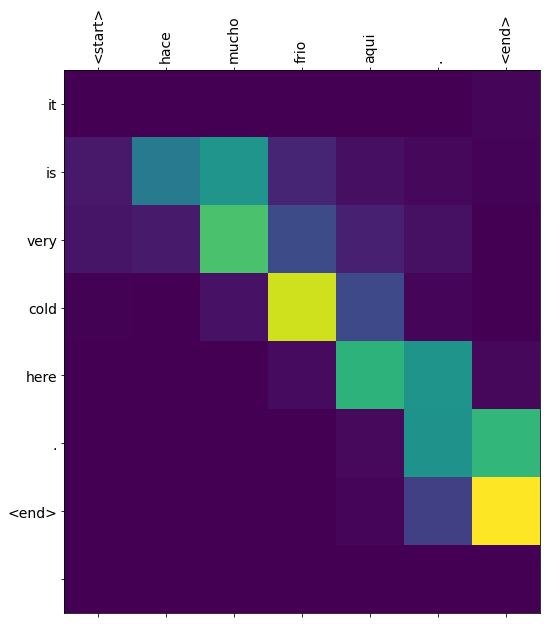

In [50]:
translate(u'hace mucho frio aqui.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


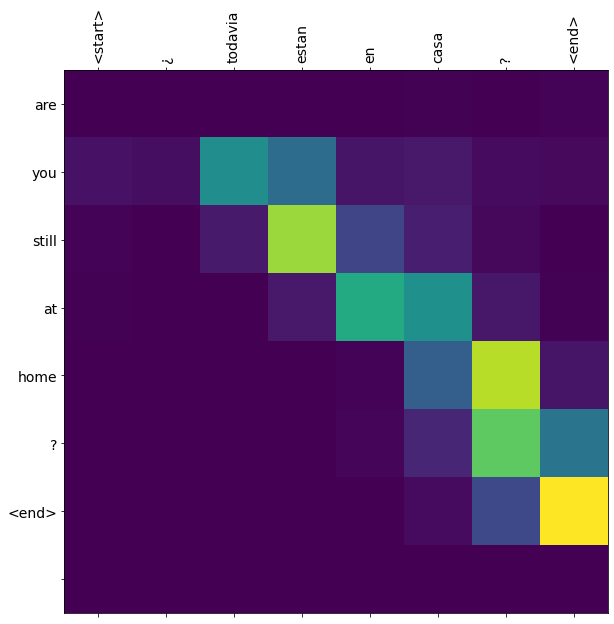

In [51]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


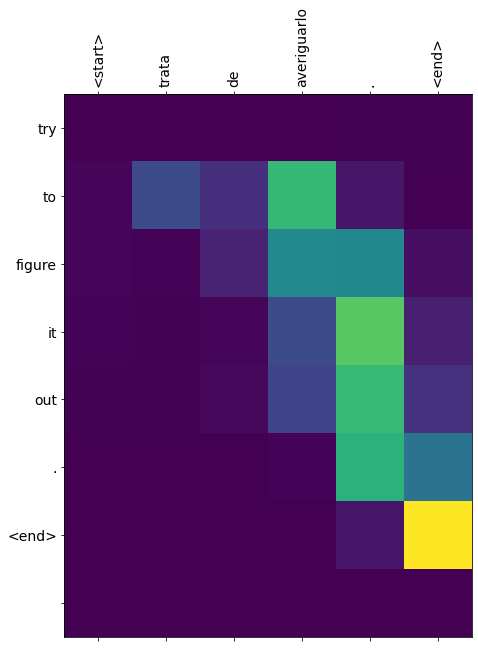

In [53]:
translate(u'trata de averiguarlo.')